In [1]:
import os, shutil
from os import walk, getcwd

In [2]:
# Retorna todos los archivos de un directorio dado
def ls(ruta):  
    return next(walk(ruta))[2]

height_image = 229
width_image = 229
channels_image = 3
nb_clases = 4
batch_size = 64
class_mode = 'categorical'
nb_train = 4000        # 1000 x 4 clases
nb_validation = 1200   #  300 x 4 clases
nb_test = 1200

base_dir = 'balanced_dataset'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

In [3]:
from keras.applications import Xception

conv_base= Xception(weights='imagenet', 
                 include_top = False, 
                 input_shape = (width_image, height_image, channels_image))

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


83689472/83683744 [==============================] - 6s 0us/step


In [4]:
conv_base.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 229, 229, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 114, 114, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 114, 114, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 114, 114, 32) 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

In [5]:
#Extracción de características del modelo Preentrenado y nuestro dataset
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical

#Tamaño de salida de la última capa convoluciónal del modelo preentrenado
#lo vemos en el conv_base.summary()
out_x = 7
out_y = 7
conv_len = 2048

datagen = ImageDataGenerator(rescale = 1./255)

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, out_x, out_x, conv_len))
    labels = to_categorical(np.zeros(shape=(sample_count)),nb_clases) #INDICAR NUMERO DE CLASES
    generator = datagen.flow_from_directory(
        directory,
        target_size = (height_image, width_image),
        batch_size = batch_size,
        #classes = 4,
        class_mode = 'categorical')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch) ##Asociamos al modelo preentrenado
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

#Train: 1000 muestras x clase, con 4 clases, 1000 x 4 = 4000
train_features, train_labels = extract_features(train_dir, nb_train)
#validation 500 muestras x clase con 4 clases, 300 x 4 = 1200
validation_features, validation_labels = extract_features(validation_dir, nb_validation) 
#test 500 muestras x clase con 4 clases, 300 x 4 = 1200
test_features, test_labels = extract_features(test_dir, nb_test)


Found 4000 images belonging to 4 classes.
Found 1200 images belonging to 4 classes.
Found 1200 images belonging to 4 classes.


In [6]:
#Las características extraídas están como muetras en forma (muestra, 4, 4, 512).-->(muestras, out_x, out_y, conv_len)
#Debemos aplanarlas (muestras, 8192) para alimentar un clasificador densamente conectado 4x4x512 = 8192 si entrada 150x150
#Debemos aplanarlas (muestras, 25088) para alimentar un clasificador densamente conectado 7x7x512 = 25088 si entrada 224x224


train_features = np.reshape(train_features, (nb_train, out_x * out_y * conv_len))
validation_features = np.reshape(validation_features, (nb_validation, out_x * out_y * conv_len))
test_features = np.reshape(test_features, (nb_test, out_x * out_y * conv_len))
print(train_features.shape)
print(validation_features.shape)
print(test_features.shape)

(4000, 100352)
(1200, 100352)
(1200, 100352)


In [7]:
#Definimos un clasificador densamente conectado capacitado con los datos y etiquetas obtenidas antes
#Aplicamos capa de abandono Dropout y función de activación "sigmoid" al final
from keras import layers
from keras import models
from keras import optimizers

top_model = models.Sequential()
top_model.add(layers.Dense(256, activation = 'relu', input_dim = out_x * out_y * conv_len))
top_model.add(layers.Dropout(0.5))
top_model.add(layers.Dense(nb_clases, activation = 'sigmoid'))  #INDICAR NUMERO DE CLASES

top_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               25690368  
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 1028      
Total params: 25,691,396
Trainable params: 25,691,396
Non-trainable params: 0
_________________________________________________________________


In [8]:
#Para la compilación usaremos el optimizador RMSprop ya que termina la red con una sola
#unidad sigmoidea, cómo función de pérdida se utiliza la entropia cruzada binaria

top_model.compile(loss = 'categorical_crossentropy', 
              optimizer = optimizers.RMSprop(lr=2e-5), 
              metrics = ['acc'])

epochs = 80

history = top_model.fit(
    train_features,
    train_labels,  
    batch_size = batch_size,
    epochs = epochs, 
    verbose = 1, 
    validation_data = (validation_features, validation_labels))



Train on 4000 samples, validate on 1200 samples
Epoch 1/80
4000/4000 [==============================] - 4s 959us/step - loss: 1.1453 - acc: 0.4652 - val_loss: 0.8367 - val_acc: 0.6308
Epoch 2/80
4000/4000 [==============================] - 3s 850us/step - loss: 0.8335 - acc: 0.6613 - val_loss: 0.7255 - val_acc: 0.6775
Epoch 3/80
4000/4000 [==============================] - 3s 865us/step - loss: 0.6995 - acc: 0.7215 - val_loss: 0.6411 - val_acc: 0.7467
Epoch 4/80
4000/4000 [==============================] - 3s 850us/step - loss: 0.6277 - acc: 0.7552 - val_loss: 0.6180 - val_acc: 0.7400
Epoch 5/80
4000/4000 [==============================] - 3s 847us/step - loss: 0.5710 - acc: 0.7678 - val_loss: 0.5455 - val_acc: 0.7775
Epoch 6/80
4000/4000 [==============================] - 4s 924us/step - loss: 0.5228 - acc: 0.7955 - val_loss: 0.5003 - val_acc: 0.7967
Epoch 7/80
4000/4000 [==============================] - 4s 878us/step - loss: 0.4857 - acc: 0.8085 - val_loss: 0.5076 - val_acc: 0.8000


In [9]:
top_model.save('Fast_Extraction_Xception_1.h5')

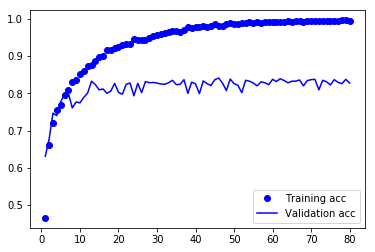

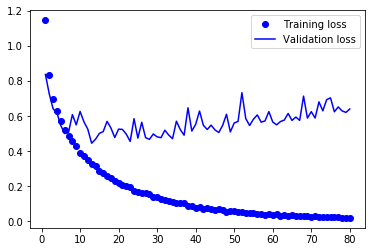

In [11]:
#Mostramos otros graficos 
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+ 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
#plt.tittle('Trainning and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
#plt.tittle('Trainning and validation loss')
plt.legend()

plt.show()

In [12]:
top_model.evaluate(test_features, test_labels)

1200/1200 [==============================] - 1s 501us/step


[0.7873209877808889, 0.7975]